C:\Users\lenovo\AppData\Local\Temp\ipykernel_10820\3084652201.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


   Index         UTC  Temperature[C]  Humidity[%]  TVOC[ppb]  eCO2[ppm]  \
0      0  1654733331          20.000        57.36          0        400   
1      1  1654733332          20.015        56.67          0        400   
2      2  1654733333          20.029        55.96          0        400   
3      3  1654733334          20.044        55.28          0        400   
4      4  1654733335          20.059        54.69          0        400   
5      5  1654733336          20.073        54.12          0        400   
6      6  1654733337          20.088        53.61          0        400   
7      7  1654733338          20.103        53.20          0        400   
8      8  1654733339          20.117        52.81          0        400   
9      9  1654733340          20.132        52.46          0        400   

   Raw H2  Raw Ethanol  Pressure[hPa]  PM1.0  PM2.5  NC0.5  NC1.0  NC2.5  CNT  \
0   12306        18520        939.735    0.0   0.00    0.0  0.000   0.00    0   
1   12345   

<Figure size 640x480 with 0 Axes>

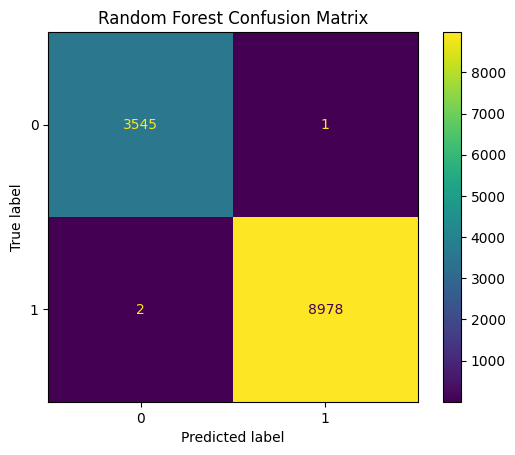

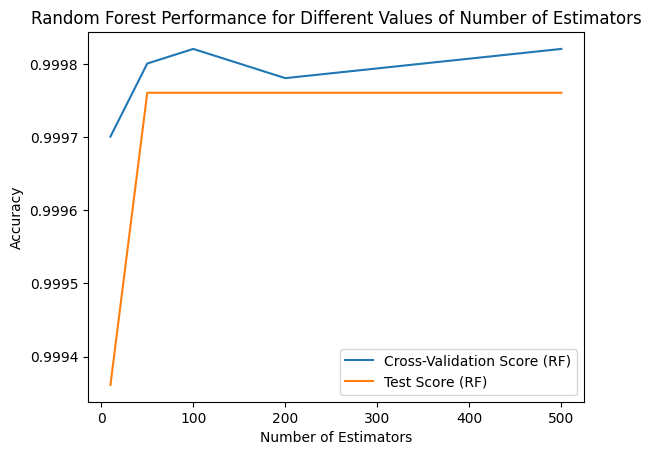

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer

# Load the dataset
df = pd.read_csv("smoke_detection_iot.csv")
# Display the first 10 rows of the dataset
print(df.head(10))

# Drop unnecessary columns
data = df.drop(['Index', 'UTC', 'CNT'], axis=1)

# Split data into features (X) and target variable (y)
X = data.drop('Fire Alarm', axis=1)
y = data['Fire Alarm']

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Normalize features
scaler = Normalizer()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier()

# Perform cross-validation to evaluate model performance
cv_scores_rf = cross_val_score(rf_classifier, X_train_normalized, y_train, cv=5)
print("Cross-Validation Scores (Random Forest):", cv_scores_rf)
print("Mean CV Accuracy (Random Forest):", np.mean(cv_scores_rf))

# Train Random Forest model on the entire training set
rf_classifier.fit(X_train_normalized, y_train)

# Make predictions on the testing set
y_pred_rf = rf_classifier.predict(X_test_normalized)

# Evaluate model performance on the testing set
print("Accuracy on Testing Set (Random Forest):", accuracy_score(y_test, y_pred_rf))
print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf))

# Plot confusion matrix for Random Forest
plt.figure()
disp_rf = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_rf))
disp_rf.plot()
plt.title("Random Forest Confusion Matrix")
plt.show()

# Varying Hyperparameter Settings (Number of Estimators)
estimators_values = [10, 50, 100, 200, 500]
cv_scores_estimators = []
test_scores_estimators = []

for n_estimators in estimators_values:
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators)
    cv_score_rf = np.mean(cross_val_score(rf_classifier, X_train_normalized, y_train, cv=5))
    cv_scores_estimators.append(cv_score_rf)
    
    rf_classifier.fit(X_train_normalized, y_train)
    y_pred_rf = rf_classifier.predict(X_test_normalized)
    test_score_rf = accuracy_score(y_test, y_pred_rf)
    test_scores_estimators.append(test_score_rf)

plt.plot(estimators_values, cv_scores_estimators, label='Cross-Validation Score (RF)')
plt.plot(estimators_values, test_scores_estimators, label='Test Score (RF)')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Random Forest Performance for Different Values of Number of Estimators')
plt.legend()
plt.show()


In [2]:
# Since it is it's difficult to definitively conclude whether there is overfitting or not
# Hence the following codefocuses on varying hyperparameter settings for the Random Forest classifier, which is one approach to addressing overfitting.

# Define a list of values for hyperparameters
max_depth_values = [None, 10, 20, 30]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]

# Initialize lists to store results
test_scores_rf = []

# Loop over each combination of hyperparameters
for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        for min_samples_leaf in min_samples_leaf_values:
            # Initialize Random Forest classifier with current hyperparameters
            rf = RandomForestClassifier(n_estimators=100, max_depth=max_depth,
                                         min_samples_split=min_samples_split,
                                         min_samples_leaf=min_samples_leaf,
                                         random_state=42)
            
            # Train Random Forest model on the entire training set
            rf.fit(X_train_normalized, y_train)
            
            # Make predictions on the testing set
            y_pred_rf = rf.predict(X_test_normalized)
            
            # Evaluate model performance on the testing set
            test_score_rf = accuracy_score(y_test, y_pred_rf)
            test_scores_rf.append(test_score_rf)

# Print the best test score and corresponding hyperparameters
best_test_score = max(test_scores_rf)
best_hyperparameters = [(max_depth_values[i], min_samples_split_values[j], min_samples_leaf_values[k])
                        for i in range(len(max_depth_values))
                        for j in range(len(min_samples_split_values))
                        for k in range(len(min_samples_leaf_values))
                        if test_scores_rf[i * len(min_samples_split_values) * len(min_samples_leaf_values) +
                                           j * len(min_samples_leaf_values) + k] == best_test_score]

print("Best Test Score:", best_test_score)
print("Best Hyperparameters:", best_hyperparameters)


Best Test Score: 0.9998403321092129
Best Hyperparameters: [(None, 2, 1), (20, 2, 1), (30, 2, 1)]
